<a href="https://colab.research.google.com/github/DataJenius/NLPEncodingExperiment/blob/main/python/NLPEncodingExperiment_onehot768.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#######################################################################################################
# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()

Finished!


In [ ]:
###########################################
# load all dependencies
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from stepbystep.v4 import StepByStep

from google.colab import files

In [ ]:
######################################################################################
# our one-hot encoded data is on github
all_files = ['https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/one_hot768/one_hot_encoded768_group1.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/one_hot768/one_hot_encoded768_group2.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/one_hot768/one_hot_encoded768_group3.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/one_hot768/one_hot_encoded768_group4.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/one_hot768/one_hot_encoded768_group5.csv']
# concat into a single dataframe and shuffle the contents
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_all_data   = pd.concat(df_from_each_file, ignore_index=True)
df_all_data = df_all_data.sample(frac=1).reset_index(drop=True)

# make sure we loaded what we think we did
print(df_all_data.head())
print(df_all_data.shape)

   msg_id  token_count  my_group   my_role  label  absolute  absolutely  act  \
0   42018           16         1     train      1         0           0    0   
1    9448           26         4  validate      0         0           0    0   
2   11571           13         1     train      0         0           0    0   
3   23445           41         2     train      1         0           0    0   
4     863           13         2     train      0         0           0    0   

   acting  action  ...  written  wrong  wrote  xb  yeah  yoda  youd  youll  \
0       0       0  ...        0      0      0   0     0     0     0      0   
1       0       0  ...        0      0      0   0     0     0     0      0   
2       0       0  ...        0      0      0   0     0     0     0      0   
3       0       0  ...        0      0      0   0     0     0     0      0   
4       1       0  ...        0      0      0   0     0     0     0      0   

   youre  youve  
0      0      0  
1      0      

In [ ]:
######################################################################################
# our data is already split into 5 groups, encoded and fully labelled

# setup this experiment
test_input_method = 'one-hot (768)'
print(test_input_method+" loading data...")

# split into val/test/train based on validation group 
df_train = df_all_data.loc[df_all_data['my_group'].isin([1,2,3])]
df_val = df_all_data.loc[df_all_data['my_group'] == 4]
df_test = df_all_data.loc[df_all_data['my_group'] == 5]

print("\n\ntrain - groups ",df_train['my_group'].unique())
print(df_train.head())
print("\n\nval - group ",df_val['my_group'].unique())
print(df_val.head())
print("\n\ntest - group ",df_test['my_group'].unique())
print(df_test.head())

# extract our labels into tensors 
train_labels_tensor = torch.as_tensor(df_train['label'].to_numpy().reshape(-1, 1)).float()
val_labels_tensor = torch.as_tensor(df_val['label'].to_numpy().reshape(-1, 1)).float()
test_labels_tensor = torch.as_tensor(df_test['label'].to_numpy().reshape(-1, 1)).float()
print("\n\nLabel Tensors:")
print("train - ",train_labels_tensor.shape)
print("val - ",val_labels_tensor.shape)
print("test - ",test_labels_tensor.shape)


# extract our features into tensors 
df_train_features = df_train.loc[:, ~df_train.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
train_features_tensor = torch.as_tensor(df_train_features.to_numpy()).float()
df_val_features = df_val.loc[:, ~df_val.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
val_features_tensor = torch.as_tensor(df_val_features.to_numpy()).float()
df_test_features = df_test.loc[:, ~df_test.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
test_features_tensor = torch.as_tensor(df_test_features.to_numpy()).float()
print("\n\nFeature Tensors:")
print("train - ",train_features_tensor.shape)
print("val - ",val_features_tensor.shape)
print("test - ",test_features_tensor.shape)


one-hot (768) loading data...


train - groups  [1 2 3]
   msg_id  token_count  my_group my_role  label  absolute  absolutely  act  \
0   42018           16         1   train      1         0           0    0   
2   11571           13         1   train      0         0           0    0   
3   23445           41         2   train      1         0           0    0   
4     863           13         2   train      0         0           0    0   
5   43739           15         2   train      1         0           0    0   

   acting  action  ...  written  wrong  wrote  xb  yeah  yoda  youd  youll  \
0       0       0  ...        0      0      0   0     0     0     0      0   
2       0       0  ...        0      0      0   0     0     0     0      0   
3       0       0  ...        0      0      0   0     0     0     0      0   
4       1       0  ...        0      0      0   0     0     0     0      0   
5       0       0  ...        0      0      0   0     0     0     0      0   

   you

In [ ]:
######################################################################################
# build a TensorDataset containing ALL data points for train/val
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)

# build a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)
print(train_loader)
print(val_loader)

In [ ]:
###############################################################################################
# use same model structure, just change embeddings into this one-hot input instead
torch.manual_seed(42)

# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/ 
model = nn.Sequential(
    nn.Linear(768, 1) 
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# get details about the model
def count_all_parameters(model):
    return sum(p.numel() for p in model.parameters())
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_all_parameters(model)
num_params_train = count_trainable_parameters(model)
print(model)
print(num_params, "total params")
print(num_params_train, "trainable params")

Sequential(
  (0): Linear(in_features=768, out_features=1, bias=True)
)
769 total params
769 trainable params


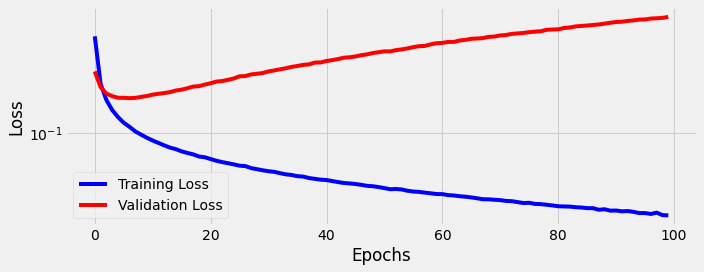

In [ ]:
###############################################################################################
# train the model - only takes about 10s for 20 epochs, 1m for 100 epochs
sbs_oh = StepByStep(model, loss_fn, optimizer)
sbs_oh.set_loaders(train_loader, val_loader)
sbs_oh.train(100)

# plot loss over epochs
fig = sbs_oh.plot_losses()

In [ ]:
##############################################################
# how well does this model do with data it has never seen?
sbs_oh.model.eval()
out = sbs_oh.model(test_features_tensor)

# record detailed predictions for this model
df_experiment_results = pd.DataFrame({'method': test_input_method,
                                      'params': num_params,
                                      'params_train': num_params_train, 
                                      'msg_id': df_test['msg_id'],
                                      'label': df_test['label'],
                                      'p_sigmoid': torch.sigmoid(out).squeeze().tolist()}) 
df_experiment_results['pred'] = np.where(df_experiment_results['p_sigmoid']>0.5, 1, 0)
df_experiment_results['correct'] = np.where(df_experiment_results['pred']==df_experiment_results['label'], 1, 0)
df_experiment_results['tp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==1), 1, 0)
df_experiment_results['fp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['tn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['fn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==1), 1, 0)

# calculate metrics
tp = df_experiment_results["tp"].sum()
fp = df_experiment_results["fp"].sum()
tn = df_experiment_results["tn"].sum()
fn = df_experiment_results["fn"].sum()
prec = tp/(tp+fp)
recall = tp/(tp+fn)

# show our metrics
print("ACC: ",df_experiment_results["correct"].mean())
print("Precision: ",prec)
print("Recall: ", recall)

# save results to local CSV
file_name = 'results_'+test_input_method+'.csv'
df_experiment_results.to_csv(file_name, index=False) 
files.download(file_name)
print("\n\n",df_experiment_results.head(10))

ACC:  0.9155
Precision:  0.9226856561546287
Recall:  0.907


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



            method  params  params_train  msg_id  label     p_sigmoid  pred  \
8   one-hot (768)     769           769   32578      1  9.996100e-01     1   
12  one-hot (768)     769           769   26132      1  9.999874e-01     1   
14  one-hot (768)     769           769   33590      1  1.000000e+00     1   
25  one-hot (768)     769           769   28493      1  9.917995e-01     1   
42  one-hot (768)     769           769   10312      0  1.401566e-20     0   
49  one-hot (768)     769           769    6114      0  4.066537e-05     0   
52  one-hot (768)     769           769   40075      1  1.000000e+00     1   
54  one-hot (768)     769           769   43414      1  9.955569e-01     1   
55  one-hot (768)     769           769   36360      1  1.847825e-01     0   
60  one-hot (768)     769           769   14337      0  9.509754e-10     0   

    correct  tp  fp  tn  fn  
8         1   1   0   0   0  
12        1   1   0   0   0  
14        1   1   0   0   0  
25        1   1   